In [1]:
import numpy as np
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers, models

IMG_SIZE_ORIG = 960
IMG_SIZE = 224
MASK_RADIUS = 25  # pixels

def get_image_path(tomo_id):
    #img_dir = '../data/pictures_process/adaptequal_05_padded'
    #img_dir = '../data/pictures_process/mean_image_padded'
    img_dir = '../data/pictures_process/adaptequal_1_padded'
    return os.path.join(img_dir, f'{tomo_id}.jpg')

def get_xy(tomo_id):
    csv_path = '../data/csv_raw/train_labels.csv'
    df = pd.read_csv(csv_path)
    y = df[df['tomo_id'] == tomo_id]['Motor_axis_1'].values[0]
    x = df[df['tomo_id'] == tomo_id]['Motor_axis_2'].values[0]
    return x, y

def get_tomo_ids():
    csv_path = '../data/csv_raw/train_labels.csv'
    df = pd.read_csv(csv_path)
    df_1_moteur = df[df['Number_of_motors'] == 1]
    return df_1_moteur['tomo_id'].unique()

X = []
Y_mask = []
for tomo_id in get_tomo_ids():
    xm, ym = get_xy(tomo_id)
    image_path = get_image_path(tomo_id)
    # Charger image grayscale, resize 224x224, stack en 3 canaux pour U-Net
    img = load_img(image_path, color_mode='grayscale', target_size=(IMG_SIZE, IMG_SIZE))
    img_array = img_to_array(img) / 255.0  # (224, 224, 1)
    img_array = np.repeat(img_array, 3, axis=2)  # (224, 224, 3)
    X.append(img_array)
    # Création du masque heatmap sans cv2
    mask = np.zeros((IMG_SIZE, IMG_SIZE), dtype=np.float32)
    x_scaled = int(xm * IMG_SIZE / IMG_SIZE_ORIG)
    y_scaled = int(ym * IMG_SIZE / IMG_SIZE_ORIG)
    yy, xx = np.ogrid[:IMG_SIZE, :IMG_SIZE]
    dist_from_center = np.sqrt((xx - x_scaled)**2 + (yy - y_scaled)**2)
    mask[dist_from_center <= MASK_RADIUS] = 1.0
    Y_mask.append(mask[..., np.newaxis])  # Shape (224,224,1)

npX = np.array(X, dtype=np.float32)
npY_mask = np.array(Y_mask, dtype=np.float32)


2025-06-05 10:41:22.173490: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models, Input

IMG_SIZE = 224
base_model = EfficientNetB0(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights='imagenet')
base_model.trainable = False

# Récupère les outputs des couches intermédiaires (pour skip connections)
skip_names = [
    "block2a_expand_activation",   # 112x112
    "block3a_expand_activation",   # 56x56
    "block4a_expand_activation",   # 28x28
    "block6a_expand_activation",   # 14x14
]
skips = [base_model.get_layer(name).output for name in skip_names]

encoder_output = base_model.output

# Decoder U-Net
x = encoder_output
for skip in reversed(skips):
    x = layers.Conv2DTranspose(x.shape[-1], 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Concatenate()([x, skip])

# Derniers upsampling
x = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')(x) # 112x112 → 224x224
x = layers.Conv2D(1, 1, activation='sigmoid', padding='same')(x)

model = models.Model(inputs=base_model.input, outputs=x)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
history = model.fit(npX, npY_mask, epochs=5, batch_size=8, validation_split=0.15)

Epoch 1/5
 4/34 [==>...........................] - ETA: 25:03 - loss: 0.3601 - accuracy: 0.7891

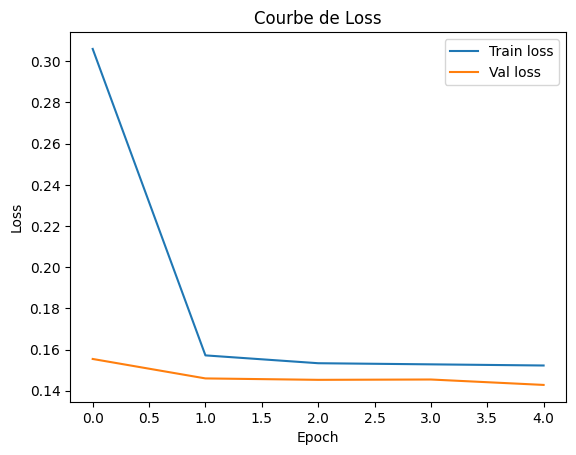

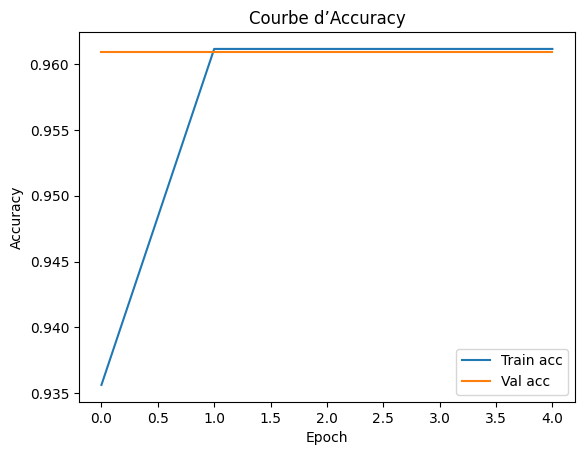

In [8]:
import matplotlib.pyplot as plt

# Affichage de la courbe de loss
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Courbe de Loss')
plt.show()

# Affichage de la courbe d’accuracy
plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Courbe d’Accuracy')
plt.show()

1/1 [==============================] - 0s 117ms/step


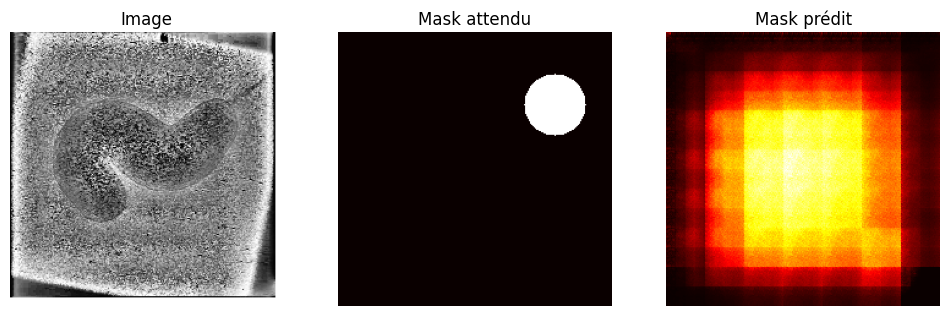

In [11]:
import matplotlib.pyplot as plt

# Sélection d’un index à afficher
idx = 5  # par exemple, la première image

# Image d’entrée
img = npX[idx]

# Masque cible
mask_true = npY_mask[idx, ..., 0]

# Masque prédit par le modèle
pred = model.predict(npX[idx:idx+1])[0, ..., 0]

# Affichage côte à côte
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(img[..., 0], cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Mask attendu")
plt.imshow(mask_true, cmap='hot')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Mask prédit")
plt.imshow(pred, cmap='hot')
plt.axis('off')

plt.show()


In [17]:
import sys
sys.path.append('../src')
from utils.render_motor_position import draw_on_image


predictions = model.predict(npX)
predictions = predictions * 960

for i in range(len(get_tomo_ids())):
    tomo_id = get_tomo_ids()[i]
    x, y = get_xy(tomo_id)
    x_pred, y_pred = predictions[i]
    image_path = get_image_path(tomo_id)
    draw_on_image(
        image_path,
        '../data/pictures_process/motor_position_predict/',
        x, y, x_pred, y_pred
    )



10/10 [==============================] - 11s 1s/step


In [18]:
predictions

array([[553.1922 , 398.26984],
       [552.1532 , 396.53766],
       [552.3698 , 398.31836],
       [554.05865, 401.5322 ],
       [554.2269 , 399.74384],
       [555.59393, 389.52472],
       [553.8713 , 388.0604 ],
       [556.2314 , 395.44183],
       [555.3321 , 396.3906 ],
       [556.9162 , 394.90228],
       [553.20386, 384.74503],
       [554.1123 , 390.517  ],
       [554.7674 , 388.33374],
       [554.9932 , 393.99203],
       [552.8092 , 394.95682],
       [554.60614, 389.20767],
       [554.07074, 390.10187],
       [555.0049 , 390.0322 ],
       [553.468  , 386.71835],
       [555.00287, 393.3576 ],
       [556.4812 , 391.23392],
       [554.91077, 395.45325],
       [557.1931 , 398.85638],
       [555.4222 , 395.0313 ],
       [553.71796, 391.1943 ],
       [553.9033 , 392.4737 ],
       [552.53436, 394.99152],
       [554.9657 , 391.21057],
       [554.04834, 389.51593],
       [555.9333 , 393.9105 ],
       [556.0986 , 395.3994 ],
       [554.751  , 390.48056],
       [

NameError: name 'model' is not defined